#### Base imports

In [1]:
%matplotlib inline
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
sns.set()

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.optim import Optimizer


import collections
import h5py, sys
import gzip
import os
import math

import pandas as pd


try:
    import cPickle as pickle
except:
    import pickle
    

from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import torchvision
import matplotlib




In [2]:
torch.cuda.empty_cache()
image_trans_size = 64
batch_size = 5
nb_epochs = 256

## Some utility functions

In [3]:
from __future__ import print_function

def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path)


import torch
from torch import nn, optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import sys

suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
def humansize(nbytes):
    i = 0
    while nbytes >= 1024 and i < len(suffixes)-1:
        nbytes /= 1024.
        i += 1
    f = ('%.2f' % nbytes)
    return '%s%s' % (f, suffixes[i])


def get_num_batches(nb_samples, batch_size, roundup=True):
    if roundup:
        return ((nb_samples + (-nb_samples % batch_size)) / batch_size)  # roundup division
    else:
        return nb_samples / batch_size

def generate_ind_batch(nb_samples, batch_size, random=True, roundup=True):
    if random:
        ind = np.random.permutation(nb_samples)
    else:
        ind = range(int(nb_samples))
    for i in range(int(get_num_batches(nb_samples, batch_size, roundup))):
        yield ind[i * batch_size: (i + 1) * batch_size]

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out
  
def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

def shuffle_in_unison_scary(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
    
import torch.utils.data as data
from PIL import Image
import numpy as np
import h5py



## Dataloader functions

In [4]:
class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

class DatafeedImage(data.Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.x_train[index]
        img = Image.fromarray(np.uint8(img))
        if self.transform is not None:
            img = self.transform(img)
        return img, self.y_train[index]

    def __len__(self):
        return len(self.x_train)

## Base network wrapper

In [5]:
import torch.nn.functional as F
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % self.lr, epoch)
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

    def save(self, filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model': self.model,
            'optimizer': self.optimizer}, filename)

    def load(self, filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        self.model = state_dict['model']
        self.optimizer = state_dict['optimizer']
        print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
        return self.epoch

## Our models

In [6]:
class Linear_2L(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Linear_2L, self).__init__()
        
        n_hid = 1200
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fc1 = nn.Linear(input_dim, n_hid)
        self.fc2 = nn.Linear(n_hid, n_hid)
        self.fc3 = nn.Linear(n_hid, output_dim)
        
        # choose your non linearity
        #self.act = nn.Tanh()
        #self.act = nn.Sigmoid()
        self.act = nn.ReLU(inplace=True)
        #self.act = nn.ELU(inplace=True)
        #self.act = nn.SELU(inplace=True)

    def forward(self, x):

        x = x.view(-1, self.input_dim) # view(batch_size, input_dim)
        # -----------------
        x = self.fc1(x)
        # -----------------
        x = self.act(x)
        # -----------------
        x = self.fc2(x)
        # -----------------
        x = self.act(x)
        # -----------------
        y = self.fc3(x)

        return y
    
    
        

In [7]:
# param_groups = list(model.parameters())

# for param in param_groups:
#     print(param.data)

## Custom SGLD optimiser

In [8]:
from torch.optim.optimizer import Optimizer, required
class SGLD(Optimizer):
    """
    SGLD optimiser based on pytorch's SGD. 
    Note that the weight decay is specified in terms of the gaussian prior sigma
    """

    def __init__(self, params, lr=required, norm_sigma=0, addnoise=True):
        
        weight_decay = 1/(norm_sigma**2)
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        
        defaults = dict(lr=lr, weight_decay=weight_decay, addnoise=addnoise)
        
        super(SGLD, self).__init__(params, defaults)

    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None
        
        for group in self.param_groups:

            weight_decay = group['weight_decay']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                    
                if group['addnoise']:
                    
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5*d_p + langevin_noise)
                else:
                    p.data.add_(-group['lr'], 0.5*d_p)

        return loss

### pSGLD optimiser


In [9]:
class pSGLD(Optimizer):
    """
    RMSprop preconditioned SGLD using pytorch rmsprop implementation.
    """

    def __init__(self, params, lr=required, norm_sigma=0, alpha=0.99, eps=1e-8, centered=False, addnoise=True):
        
        weight_decay = 1/(norm_sigma**2)
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        defaults = dict(lr=lr, weight_decay=weight_decay, alpha=alpha, eps=eps, centered=centered, addnoise=addnoise)
        super(pSGLD, self).__init__(params, defaults)
        
    def __setstate__(self, state):
        super(pSGLD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('centered', False)

    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None

        for group in self.param_groups:
            
            weight_decay = group['weight_decay']
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                
                state = self.state[p]
                
                if len(state) == 0:
                    state['step'] = 0
                    state['square_avg'] = torch.zeros_like(p.data)
                    if group['centered']:
                        state['grad_avg'] = torch.zeros_like(p.data)
                        
                square_avg = state['square_avg']
                alpha = group['alpha']
                state['step'] += 1
                
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                
                # sqavg x alpha + (1-alph) sqavg *(elemwise) sqavg
                square_avg.mul_(alpha).addcmul_(1-alpha, d_p, d_p)
                
                if group['centered']:
                    grad_avg = state['grad_avg']
                    grad_avg.mul_(alpha).add_(1-alpha, d_p)
                    avg = square_avg.cmul(-1, grad_avg, grad_avg).sqrt().add_(group['eps'])
                else:
                    avg = square_avg.sqrt().add_(group['eps'])
                    
#                 print(avg.shape)
                if group['addnoise']:
                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1)/np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5*d_p.div_(avg) + langevin_noise/torch.sqrt(avg))
                    
                else:
                    p.data.addcdiv_(-group['lr'], 0.5*d_p, avg)


        return loss

## Network wrapper

In [10]:
from __future__ import division
import copy

class Net_langevin(BaseNet):
    eps = 1e-6

    def __init__(self, lr=1e-3, channels_in=1, side_in=224, cuda=True, classes=2, N_train=300, prior_sig=0):
        super(Net_langevin, self).__init__()
        cprint('y', ' Creating Net!! ')
        self.lr = lr
        self.schedule = None  # [] #[50,200,400,600]
        self.cuda = cuda
        self.channels_in = channels_in
        self.prior_sig = prior_sig
        self.classes = classes
        self.N_train = N_train
        self.side_in=side_in
        self.create_net()
        self.create_opt()
        self.epoch = 0
        
        self.weight_set_samples = []

        self.test=False

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        self.model = Linear_2L(input_dim = self.channels_in * self.side_in * self.side_in, output_dim=self.classes)
        if self.cuda:
            self.model.cuda()
#             cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
#         self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999), eps=1e-08,
#                                           weight_decay=0)
        self.optimizer = SGLD(params=self.model.parameters(), lr=self.lr, norm_sigma=self.prior_sig, addnoise=True)
#         self.optimizer = pSGLD(params=self.model.parameters(), lr=self.lr, norm_sigma=self.prior_sig, addnoise=True)

    #         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
#         self.sched = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=10, last_epoch=-1)

    def fit(self, x, y):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        self.optimizer.zero_grad()

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='mean') # We use mean because we treat as an estimation of whole dataset
        loss = loss * self.N_train 
            
        loss.backward()
        self.optimizer.step()

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data*x.shape[0]/self.N_train, err

    def eval(self, x, y, train=False):
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)

        loss = F.cross_entropy(out, y, reduction='sum')

        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def save_sampled_net(self, max_samples):
        
        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)
            
        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))
        
        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples) )
        
        return None
        
    def sample_eval(self, x, y, Nsamples=0, logits=True, train=False):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        
        if logits:
            mean_out = out.mean(dim=0, keepdim=False)
            loss = F.cross_entropy(mean_out, y, reduction='sum')
            probs = F.softmax(mean_out, dim=1).data.cpu()
            
        else:
            mean_out =  F.softmax(out, dim=2).mean(dim=0, keepdim=False)
            probs = mean_out.data.cpu()
            
            log_mean_probs_out = torch.log(mean_out)
            loss = F.nll_loss(log_mean_probs_out, y, reduction='sum')

        pred = mean_out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs
    
    def all_sample_eval(self, x, y, Nsamples):
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
            
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        
        out = x.data.new(Nsamples, x.shape[0], self.classes)
        
        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)
        
        prob_out =  F.softmax(out, dim=2)
        prob_out = prob_out.data

        return prob_out
    
    def get_weight_samples(self, Nsamples=0):
        weight_vec = []
        
        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)
            
        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
                
            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu().data
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)
            
        return np.array(weight_vec)

In [11]:


transform_covid19 = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=(0, 180)),
        transforms.Resize(image_trans_size),
        transforms.CenterCrop(image_trans_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1)
])
    
    
trainset = torchvision.datasets.ImageFolder(root="../data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="../data/COVID/test", transform=transform_covid19)
num_classes = 2
inputs = 3

In [12]:
print(trainset.targets)
print(sum(trainset.targets))


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
150


In [13]:
trainset.class_to_idx

{'0noncovid': 0, '1covid': 1}

In [14]:
k15 = trainset[0][0].cpu().numpy()
k15 = np.concatenate(k15)
k15

array([[-2.0163302, -2.0163302, -2.0163302, ..., -2.0163302, -2.0163302,
        -2.0163302],
       [-2.0163302, -2.0163302, -2.0163302, ..., -2.0163302, -2.0163302,
        -2.0163302],
       [-2.0163302, -2.0163302, -2.0163302, ..., -1.8077447, -1.9641838,
        -2.0163302],
       ...,
       [ 1.7729735,  1.7729735,  1.7729735, ...,  1.7555914,  1.7382094,
         1.6860629],
       [ 1.7729735,  1.7729735,  1.7729735, ...,  1.7555914,  1.7555914,
         1.7208272],
       [ 1.7729735,  1.7729735,  1.7729735, ...,  1.7555914,  1.7555914,
         1.7208272]], dtype=float32)

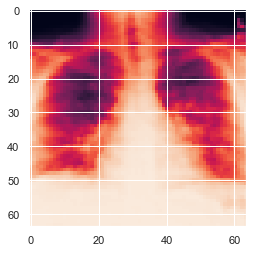

In [15]:
plt.imshow(k15)

In [16]:
train_data_len = len(trainset.targets)
test_data_len = len(valset.targets)

In [ ]:



models_dir = 'models_SGLD_COVID150'
results_dir = 'results_SGLD_COVID150'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
NTrainPoints = train_data_len
#batch_size = 20
#nb_epochs = 100 # We can do less iterations as this method has faster convergence
log_interval = 1

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


# load data

# data augmentation
# transform_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

use_cuda = torch.cuda.is_available()

# trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
# valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-5
prior_sig = 0.1
########################################################################################
net = Net_langevin(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=2, N_train=NTrainPoints, prior_sig=prior_sig)

epoch = 0

## weight saving parameters #######
start_save = 15
save_every = 2 # We want less correlated samples -> despite having per minibatch noise we see correlations
N_saves = 90
###################################


## ---------------------------------------------------------------------------------------------------------------------
# train
cprint('c', '\nTrain:')

print('  init cost variables:')
pred_cost_train = np.zeros(nb_epochs)
err_train = np.zeros(nb_epochs)

cost_dev = np.zeros(nb_epochs)
err_dev = np.zeros(nb_epochs)
# best_cost = np.inf
best_err = np.inf


nb_its_dev = 1

tic0 = time.time()
for i in range(epoch, nb_epochs):
    
#     if i in [1]:
#         print('updating lr')
#         net.sched.step()
    
    net.set_mode_train(True)

    tic = time.time()
    nb_samples = 0

    for x, y in trainloader:

        cost_pred, err = net.fit(x, y)

        err_train[i] += err
        pred_cost_train[i] += cost_pred
        nb_samples += len(x)

    pred_cost_train[i] /= nb_samples
    err_train[i] /= nb_samples

    toc = time.time()
    net.epoch = i
    # ---- print
    print("it %d/%d, Jtr_pred = %f, err = %f, " % (i, nb_epochs, pred_cost_train[i], err_train[i]), end="")
    cprint('r', '   time: %f seconds\n' % (toc - tic))
    
    # ---- save weights
    if i >= start_save and i % save_every == 0:
        net.save_sampled_net(max_samples=N_saves)

    # ---- dev
    if i % nb_its_dev == 0:
        net.set_mode_train(False)
        nb_samples = 0
        for j, (x, y) in enumerate(valloader):

            cost, err, probs = net.eval(x, y)

            cost_dev[i] += cost
            err_dev[i] += err
            nb_samples += len(x)

        cost_dev[i] /= nb_samples
        err_dev[i] /= nb_samples

        cprint('g', '    Jdev = %f, err = %f\n' % (cost_dev[i], err_dev[i]))

        if err_dev[i] < best_err:
            best_err = err_dev[i]
            cprint('b', 'best test error')
#             net.save(models_dir+'/theta_best.dat')

toc0 = time.time()
runtime_per_it = (toc0 - tic0) / float(nb_epochs)
cprint('r', '   average time: %f seconds\n' % runtime_per_it)



## ---------------------------------------------------------------------------------------------------------------------
# results
cprint('c', '\nRESULTS:')
nb_parameters = net.get_nb_parameters()
best_cost_dev = np.min(cost_dev)
best_cost_train = np.min(pred_cost_train)
err_dev_min = err_dev[::nb_its_dev].min()

print('  cost_dev: %f (cost_train %f)' % (best_cost_dev, best_cost_train))
print('  err_dev: %f' % (err_dev_min))
print('  nb_parameters: %d (%s)' % (nb_parameters, humansize(nb_parameters)))
print('  time_per_it: %fs\n' % (runtime_per_it))



## Save results for plots
# np.save('results/test_predictions.npy', test_predictions)
np.save(results_dir + '/cost_train.npy', pred_cost_train)
np.save(results_dir + '/cost_dev.npy', cost_dev)
np.save(results_dir + '/err_train.npy', err_train)
np.save(results_dir + '/err_dev.npy', err_dev)

## ---------------------------------------------------------------------------------------------------------------------
# fig cost vs its

textsize = 15
marker=5


 
 
 


Data:

Network:

Net:
 Creating Net!! 
    Total params: 6.36M

Train:
  init cost variables:


C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_29824/2912214083.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return np.sum(p.numel() for p in self.model.parameters())
C:\Users\SHUAIZ~1\AppData\Local\Temp/ipykernel_29824/2292766602.py:36: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  d_p.add_(weight_decay, p.data)


it 0/256, Jtr_pred = 0.673796, err = 0.403333,    time: 9.062880 seconds

    Jdev = 0.685040, err = 0.400000

best test error
it 1/256, Jtr_pred = 0.800785, err = 0.360000,    time: 6.528958 seconds

    Jdev = 0.824738, err = 0.412500

it 2/256, Jtr_pred = 1.375854, err = 0.406667,    time: 6.373039 seconds

    Jdev = 2.445482, err = 0.500000

it 3/256, Jtr_pred = 1.354033, err = 0.353333,    time: 6.918093 seconds

    Jdev = 2.441070, err = 0.525000

it 4/256, Jtr_pred = 1.601261, err = 0.323333,    time: 6.450605 seconds

    Jdev = 3.199146, err = 0.450000

it 5/256, Jtr_pred = 2.247107, err = 0.323333,    time: 6.631807 seconds

    Jdev = 2.870368, err = 0.475000

it 6/256, Jtr_pred = 2.593292, err = 0.293333,    time: 6.278807 seconds

    Jdev = 2.091655, err = 0.437500

it 7/256, Jtr_pred = 2.595288, err = 0.323333,    time: 6.389802 seconds

    Jdev = 2.735255, err = 0.337500

best test error
it 8/256, Jtr_pred = 1.997540, err = 0.230000,    time: 6.554022 seconds

    Jd

 saving weight samples 21/90
    Jdev = 8.227402, err = 0.362500

it 57/256, Jtr_pred = 3.013159, err = 0.173333,    time: 6.363012 seconds

    Jdev = 3.326008, err = 0.275000

it 58/256, Jtr_pred = 0.936915, err = 0.110000,    time: 6.305319 seconds

 saving weight samples 22/90
    Jdev = 4.773790, err = 0.212500

it 59/256, Jtr_pred = 2.226723, err = 0.130000,    time: 6.251807 seconds

    Jdev = 17.966046, err = 0.425000

it 60/256, Jtr_pred = 2.100862, err = 0.156667,    time: 6.277806 seconds

 saving weight samples 23/90
    Jdev = 7.081643, err = 0.275000

it 61/256, Jtr_pred = 1.381646, err = 0.100000,    time: 6.677794 seconds

    Jdev = 4.297960, err = 0.262500

it 62/256, Jtr_pred = 4.111375, err = 0.210000,    time: 6.863139 seconds

 saving weight samples 24/90
    Jdev = 9.671531, err = 0.412500

it 63/256, Jtr_pred = 2.427738, err = 0.150000,    time: 6.555125 seconds

    Jdev = 5.328130, err = 0.262500

it 64/256, Jtr_pred = 1.746715, err = 0.143333,    time: 6.381

In [ ]:
plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.plot(pred_cost_train, 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
#plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.plot(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
#plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), box_inches='tight')


In [ ]:

textsize = 15
marker=5

plt.figure(dpi=100)
fig, ax1 = plt.subplots()
ax1.plot(range(0, nb_epochs, nb_its_dev), cost_dev[::nb_its_dev], 'b-')
ax1.plot(pred_cost_train, 'r--')
ax1.set_ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
plt.title('classification costs')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/cost.png', bbox_extra_artists=(lgd,), bbox_inches='tight')



plt.figure(dpi=100)
fig2, ax2 = plt.subplots()
ax2.set_ylabel('% error')
ax2.plot(range(0, nb_epochs, nb_its_dev), 100 * err_dev[::nb_its_dev], 'b-')
ax2.plot(100 * err_train, 'r--')
plt.xlabel('epoch')
plt.grid(b=True, which='major', color='k', linestyle='-')
plt.grid(b=True, which='minor', color='k', linestyle='--')
ax2.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
ax2.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
lgd = plt.legend(['test error', 'train error'], markerscale=marker, prop={'size': textsize, 'weight': 'normal'})
ax = plt.gca()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(textsize)
    item.set_weight('normal')
plt.savefig(results_dir + '/err.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

### save models

In [ ]:
def save_object(obj, filename):
    with open(filename, 'wb') as output:  # Overwrites any existing file.
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)
        
save_object(net.weight_set_samples, models_dir+'/state_dicts.pkl')

## Load Models

In [ ]:
from __future__ import print_function
from __future__ import division
import time
import torch.utils.data
from torchvision import transforms, datasets
import matplotlib




In [ ]:



models_dir = 'models_SGLD_COVID150'
results_dir = 'results_SGLD_COVID150'

mkdir(models_dir)
mkdir(results_dir)
# ------------------------------------------------------------------------------------------------------
# train config
#NTrainPointsMNIST = 300
#batch_size = 128
#nb_epochs = 200 # We can do less iterations as this method has faster convergence
log_interval = 1

# ------------------------------------------------------------------------------------------------------
# dataset
cprint('c', '\nData:')


# load data

# data augmentation
# transform_train = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.1307,), std=(0.3081,))
# ])

# use_cuda = torch.cuda.is_available()

# trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform_train)
# valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform_test)

transform_covid19 = transforms.Compose([
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        #transforms.RandomRotation(degrees=(0, 180)),
        transforms.Resize(image_trans_size),
        transforms.CenterCrop(image_trans_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=1)
])
    
    
trainset = torchvision.datasets.ImageFolder(root="../data/COVID/train", transform=transform_covid19)
valset = torchvision.datasets.ImageFolder(root="../data/COVID/test", transform=transform_covid19)
num_classes = 2
inputs = 3


if use_cuda:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=3)

else:
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                              num_workers=3)
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=3)


## ---------------------------------------------------------------------------------------------------------------------
# net dims
cprint('c', '\nNetwork:')

lr = 1e-5
prior_sig = 0.1
########################################################################################
net = Net_langevin(lr=lr, channels_in=1, side_in=image_trans_size, cuda=use_cuda, classes=2, N_train=NTrainPoints, prior_sig=prior_sig)




with open(models_dir+'/state_dicts.pkl', 'rb') as input:
    net.weight_set_samples = pickle.load(input)
    
    

#### 

## inference with sampling on test set

In [ ]:
#batch_size = 200

if use_cuda:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4)

else:
    valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            num_workers=4)
test_cost = 0  # Note that these are per sample
test_err = 0
nb_samples = 0
test_predictions = np.zeros((test_data_len, 2))

Nsamples = 90

net.set_mode_train(False)

for j, (x, y) in enumerate(valloader):
    cost, err, probs = net.sample_eval(x, y, Nsamples, logits=False) # , logits=True

    test_cost += cost
    test_err += err.cpu().numpy()
    test_predictions[nb_samples:nb_samples+len(x), :] = probs.numpy()
    nb_samples += len(x)

# test_cost /= nb_samples
test_err /= nb_samples
cprint('b', '    Loglike = %5.6f, err = %1.6f\n' % (-test_cost, test_err))



In [ ]:
import matplotlib.pyplot as plt
import scipy.ndimage as ndim
import matplotlib.colors as mcolors
x_dev = []
y_dev = []
for x, y in valloader:
    x_dev.append(x.cpu().numpy())
    y_dev.append(y.cpu().numpy())

x_dev = np.concatenate(x_dev)
y_dev = np.concatenate(y_dev)
print(x_dev.shape)
print(y_dev.shape)

In [ ]:
im_ind = np.random.randint(0, y_dev.shape[0])
#im_ind = 90
print("image number:", im_ind)


x, y = x_dev[im_ind], y_dev[im_ind]
x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)

print("real number:",y)

plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
plt.show()

ims=[]


ims.append(x_rot[:,:,:])


ims = np.concatenate(ims)

net.set_mode_train(False)

y = np.ones(ims.shape[0])*y
ims = np.expand_dims(ims, axis=1)

cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True

predictions = probs.numpy()

print("predictions", predictions)

print("error", err.cpu().numpy())


# predictions.max(axis=1)[0]
# selections = (predictions[:,i] == predictions.max(axis=1))
print("predict", predictions.argmax())





In [ ]:
im_ind

In [ ]:
valset[im_ind][1]

In [ ]:
valset.class_to_idx

In [ ]:
y_true = []
y_pred = []
prob = []
for i in range(0,test_data_len):
    x, y = x_dev[i], y_dev[i]
    x_rot = np.expand_dims(ndim.interpolation.rotate(x[0, :, :], 0, reshape=False, cval=-0.42421296), 0)
    #print("real number:",y)
    y_true.append(y)
    #plt.imshow( ndim.interpolation.rotate(x_dev[im_ind,0,:,:], 0, reshape=False))
    #plt.show()
    ims=[]
    ims.append(x_rot[:,:,:])
    ims = np.concatenate(ims)
    net.set_mode_train(False)
    y = np.ones(ims.shape[0])*y
    ims = np.expand_dims(ims, axis=1)
    cost, err, probs = net.sample_eval(torch.from_numpy(ims), torch.from_numpy(y), Nsamples=Nsamples, logits=False) # , logits=True
    predictions = probs.numpy()
    prob.append(predictions)
#     print("predictions", predictions)
#     print("error", err.cpu().numpy())
    y_pred.append(predictions.argmax())
    torch.cuda.empty_cache()

In [ ]:
print(y_pred)

In [ ]:
prob

In [ ]:
sns.set()

f, ax2 = plt.subplots(figsize = (10, 8), nrows=1)

C2= confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
print(C2)
print(C2.ravel())
sns.heatmap(C2,annot=True)

ax2.set_title('confusion_matrix')
ax2.set_xlabel('Pred')
ax2.set_ylabel('True')

In [ ]:
"Accuracy: "+str(round((tp+tn)/(tp+fp+fn+tn), 3))

In [ ]:

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=2)
print("fpr:{},tpr:{},thresholds:{}".format(fpr,tpr,thresholds))
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

plt.plot(fpr, tpr, lw=1, label="TB vs nonTB, area=%0.2f)" % (roc_auc))

plt.xlim([0.00, 1.0])
plt.ylim([0.00, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.savefig(r"./ROC.png")

In [ ]:
torch.cuda.empty_cache()

In [ ]:
thres = np.arange(0,1,0.01)
thres.shape

In [ ]:
prob = np.array(prob)
prob = prob.reshape(80,2)

In [ ]:
tnl=[]
fpl=[]
fnl=[]
tpl=[]
acc=[]
y_true = np.append(np.zeros(40),np.ones(40))
for j in range(0, thres.shape[0]):
    y_pred=[]
    for i in range(0,prob.shape[0]):
        if prob[i][1] >= thres[j]:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    tnl.append(tn)
    fpl.append(fp)
    fnl.append(fn)
    tpl.append(tp)
    acc.append(round((tp+tn)/(tp+fp+fn+tn), 3))
    
    
tnl = np.array(tnl)
fpl = np.array(fpl)
fnl = np.array(fnl)
tpl = np.array(tpl)
acc = np.array(acc)

plt.plot(thres, tnl, '.')
plt.plot(thres, fpl, '-')
plt.plot(thres, fnl, 'o')
plt.plot(thres, tpl, '-.')
plt.plot(thres, acc*100, '*')
plt.legend(['True negetive', 'False positive','False negetive','True positive', 'acc'])
plt.xlabel("threshold")

In [ ]:
mat = np.array([acc, thres,tnl,fpl,fnl,tpl])

In [ ]:
c=np.where(acc==np.max(acc))
print('max acc is', acc[c])
print('max of acc is at', c)
print('corr threshold is',thres[c])
print('True negetive is', tnl[c])
print('False positive', fpl[c])
print('False negetive is', fnl[c])
print('True positive is', tpl[c])

In [ ]:
mat = pd.DataFrame(mat,  index = [' acc', 'threshold', 'TN', 'FP','FN','TP'])

In [ ]:
pd.set_option('display.max_columns', None) 

In [ ]:
mat

In [ ]:
torch.cuda.empty_cache()